# Aufgabe 1

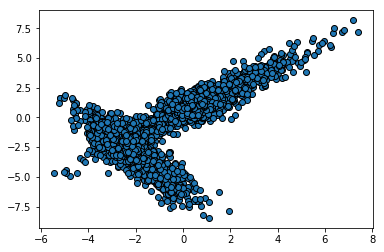

In [1]:
%matplotlib inline
import sys
import numpy as np
import cudamat as cm
import random as rd
import numpy.random as nprd
import pandas as pd
import matplotlib.pyplot as plt

folderpath = 'E:/Users/Tanui/Documents/Uni/info/MachineLearning/'
filename = '2d-em.csv'
data = pd.read_csv(folderpath+filename, header=None).as_matrix()

plt.scatter(*zip(*data), edgecolors='black')

In [2]:
def exmax(data, k, limit=30):
    #Select k random start values from the provided data, add noise:
    dim = len(data[0])
    mu = [data[i] for i in rd.sample(range(len(data)),k)]
    Sigma = [np.zeros(dim) for x in range(k)]
    Sigmai = [np.identity(dim) for x in range(k)]
    mapping = [-1]*len(data)
    change, count = True, 0
    while(change and count < limit):
        change = False
        points = [[] for i in range(k)]
        for i in range(len(data)):
            cluster = min(range(k), key=lambda j: np.dot(data[i]-mu[j], np.dot(Sigmai[j], data[i]-mu[j])))
            points[cluster].append(data[i])
            change = change or (mapping[i] != cluster)
            mapping[i] = cluster
        #print(','.join([str(len(x)) for x in points]))
        for i in range(k):
            if(len(points[i])>0):
                mu[i] = sum(points[i])/len(points[i])
        #mu = [sum(points[i])/len(points[i]) if len(points[i])>0 else mu[i] for i in range(k)]
        Sigmai = []
        for i in range(k):
            if(len(points[i]) > 0):
                Sigma[i] = np.cov(np.array(points[i]).transpose())
                try:
                    Sigmai.append(np.linalg.inv(Sigma[i]))
                except:
                    Sigmai.append(np.identity(dim))
            else:
                Sigmai.append(np.identity(dim))
        #Sigmai = [np.linalg.inv( for i in range(k)]
        count += 1
        sys.stdout.write(str(count) + ' iterations.\r')
    return(mu, Sigma)
        

In [4]:
def plot(mu, Sigma, k):
    plt.scatter(*zip(*data), edgecolors='black')
    plt.scatter(*zip(*mu))

    arcs = np.linspace(0, 2 * np.pi, 100)
    xy = [[np.sin(x), np.cos(x)] for x in arcs]
    for i in range(k):
        xydata = np.dot(Sigma[i], np.transpose(np.array(xy))) + mu[i].reshape(2,1)
        plt.plot(*xydata, 'tab:orange')
    plt.show()

In [5]:
def exmax_(data, k, limit=30, gpu=False, reti=False):
    #If standard memory exceeded, allocates more space:
    if(gpu):
        if(data.shape[0] > 256*1024):
            cm.init(data.shape[0])
        else:
            cm.init()
    #Select k random start values from the provided data, add noise:
    dim = len(data[0])
    mu = [data[i] for i in rd.sample(range(len(data)),k)]
    #mu = data[rd.sample(range(len(data)),k)]
    Sigma = [np.zeros(dim) for x in range(k)]
    Sigmai = [np.identity(dim) for x in range(k)]
    clusters = np.repeat(-1, k)
    count = 0
    indexlist = [np.empty(0) for i in range(k)]
    while(count < limit):
        distances = []
        clusters_ = None
        if(gpu):
            for i in range(k):
                x_gpu = cm.CUDAMatrix(data)
                mu_gpu = cm.CUDAMatrix(mu[i].reshape(1,dim))
                mu_gpu.mult(-1)
                x_gpu.add_row_vec(mu_gpu)
                Sigma_gpu = cm.CUDAMatrix(Sigmai[i])
                x_gpu_ = cm.dot(x_gpu, Sigma_gpu)
                x_gpu.mult(x_gpu_)
                x_gpu_sum = x_gpu.sum(axis = 1)
                res = x_gpu_sum.asarray()
                del x_gpu, mu_gpu, Sigma_gpu, x_gpu_, x_gpu_sum
                distances.append(res)
                
            clusters_ = np.argmin(np.column_stack(distances), axis=1)
            if(np.array_equal(clusters, clusters_)):
                break;
            else:
                clusters = clusters_
                for i in range(k):
                    indices = np.where(clusters == i)[0]
                    if(reti):
                        indexlist[i] = indices
                    if(len(indices) != 0):
                        vectors_i = np.take(data, indices , axis=0)
                        vectors_i_gpu = cm.CUDAMatrix(vectors_i)
                        mean = vectors_i_gpu.mean(axis=0)
                        mu[i] = np.reshape(mean.asarray(), dim)
                        mean.mult(-1)
                        vectors_i_gpu.add_row_vec(mean)
                        cov = cm.dot(vectors_i_gpu.T, vectors_i_gpu)
                        cov.divide(vectors_i_gpu.shape[0])
                        Sigma[i] = cov.asarray()
                        del vectors_i_gpu, mean, cov
                        try:
                            Sigmai[i] = np.linalg.inv(Sigma[i])
                        except:
                            pass
        else:
            for i in range(k):
                x = data - mu[i]
                distances.append(np.sum(np.multiply(np.dot(x, Sigmai[i]), x), axis=1))
            clusters_ = np.argmin(np.column_stack(distances), axis=1)
            if(np.array_equal(clusters, clusters_)):
                break;
            else:
                clusters = clusters_
                for i in range(k):
                    indices = np.where(clusters == i)[0]
                    if(len(indices) != 0):
                        vectors_i = np.take(data, indices , axis=0)
                        mu[i] = np.sum(vectors_i, axis=0)/vectors_i.shape[0]
                        Sigma[i] = np.cov(np.transpose(vectors_i))
                        try:
                            Sigmai[i] = np.linalg.inv(Sigma[i])
                        except:
                            pass
        count += 1
        sys.stdout.write(str(count) + ' iterations.\r')
    if(gpu):
        cm.shutdown()
    #print(mu,Sigma)
    if(reti):
        return(mu, Sigma, indexlist)
    else:
        return(mu, Sigma)

Wall time: 972 ms


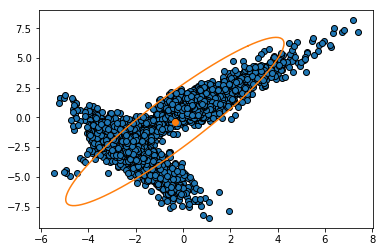

Wall time: 455 ms


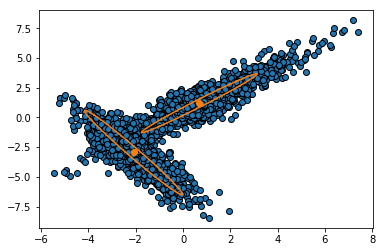

Wall time: 821 ms


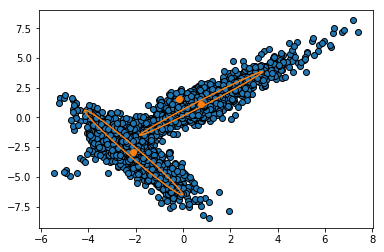

Wall time: 903 ms


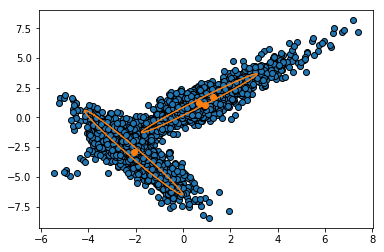

Wall time: 1.07 s


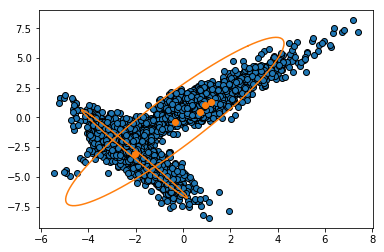

<Container object of 5 artists>

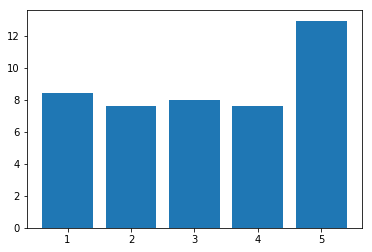

In [6]:
quality = []
for k in range(1, 6):
    %time mu, Sigma = exmax_(data, k, gpu=True)
    quality.append(sum([np.linalg.norm(Sigma[i]) for i in range(k)]))
    plot(mu, Sigma, k)

plt.bar(range(1,6), quality, align='center')


# Aufgabe2

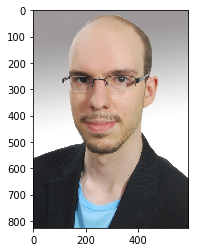

In [192]:
folderpath2 = 'E:/Users/Tanui/Pictures/bewerbungsfotos/'
filename2 = 'DSC_0030 5x7.jpg'
from PIL import Image
img = Image.open(folderpath2 + filename2)
arr = np.array(img)
plt.imshow(arr)
data2 = arr.copy()
data2 = np.reshape(data2,[data2.shape[0]*data2.shape[1],data2.shape[2]])

In [206]:
#%time mu, Sigma = exmax_(dat,20,20)
%time mu, Sigma, indexl = exmax_(dat,20,20, gpu=True, reti=True)

Wall time: 12.5 s


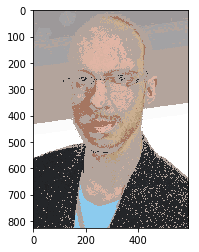

In [207]:
data2_mod = data2.copy()
mu = np.round(np.row_stack(mu)).astype(np.uint8)
for i in range(len(indexl)):
    if(len(indexl[i]) > 0):
        data2_mod[indexl[i]] = mu[i]
data2_mod = np.reshape(data2_mod, arr.shape)
data2_mod.shape
plt.imshow(data2_mod)